# Importação das bibliotecas

In [1]:
from glob import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import shutil
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch import optim
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.model_selection import StratifiedKFold
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Verificação da disponibilidade da GPU

In [2]:
is_cuda = False
if torch.cuda.is_available():
    is_cuda = True

# Carregar dados em tensores PyTorch

In [3]:
# Função usada para exibir uma imagem representada como um tensor.
def imshow(inp,cmap=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Converte o tensor de entrada inp em uma matriz NumPy e transpõe as
    # dimensões para que a ordem dos eixos seja (1, 2, 0) (altura, largura, canais).
    mean = np.array([0.485, 0.456, 0.406])  # Contém os valores médios para normalização da imagem. Esses valores são
    # usados para reverter a normalização aplicada durante o pré-processamento da imagem.
    std = np.array([0.229, 0.224, 0.225])  # Contém os desvios padrão para normalização da imagem. São usados para
    # reverter a normalização aplicada durante o pré-processamento da imagem.
    inp = std * inp + mean  # Aplica a reversão da normalização à imagem.
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap)


In [4]:
simple_transform = transforms.Compose([transforms.Resize((224, 224))
                                       ,transforms.ToTensor()
                                       ,transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                      ])
train = ImageFolder('/kaggle/input/cats-dogs/dogsandcats/train', simple_transform)
valid = ImageFolder('/kaggle/input/cats-dogs/dogsandcats/valid', simple_transform)

In [5]:
print(train.class_to_idx)
print(train.classes)

{'cat': 0, 'dog': 1}
['cat', 'dog']


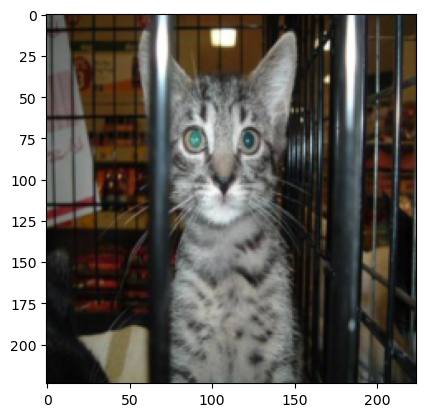

In [6]:
imshow(valid[770][0])

# Arquitetura do modelo

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Primeira camada convolucional com 32 filtros de tamanho 5x5, operando 
        # em uma imagem com 3 canais de entrada.
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=5)
        
        # Primeira camada totalmente conectada com 256 neurônios. A entrada 
        # é achatada em um vetor de tamanho 128 * 10 * 10 -> pixel(filtro) * 
        # altura * largura
        self.fc1 = nn.Linear(128 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 2)
        
        # Uma camada de dropout é definida aqui com uma taxa de 0.5. O dropout 
        # ajuda a regularizar a rede, desativando aleatoriamente alguns neurônios 
        # durante o treinamento para evitar o overfitting.
        self.dropout = nn.Dropout(0.5)
    
        # Adiciona uma camada de normalização em lote (batch normalization) após 
        # a primeira camada convolucional. Isso ajuda a regularizar o treinamento, 
        # tornando-o mais estável e permitindo que as camadas subsequentes recebam 
        # entradas mais consistentes.
        self.batch_norm1 = nn.BatchNorm2d(32)
        self.batch_norm2 = nn.BatchNorm2d(64)
        self.batch_norm3 = nn.BatchNorm2d(128)
        self.batch_norm4 = nn.BatchNorm2d(128)

    # verbose=False, é usado para controlar a saída de informações adicionais durante 
    # o processo de passagem direta (forward pass) da rede neural.
    def forward(self, x, verbose=False):
        # Após a convolução inicial, os valores de ativação passam pela camada de 
        # normalização em lote antes da função de ativação ReLU. Isso ajuda a 
        # controlar a distribuição dos valores de ativação ao longo do treinamento, 
        # o que pode levar a um treinamento mais rápido e estável da rede.
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv3(x)
        x = self.batch_norm3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv4(x)
        x = self.batch_norm4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = x.view(-1, 128*10*10)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x

# Função de treinamento e validação

In [9]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data,target) in enumerate(data_loader):
        if is_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile), Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)

        running_loss += F.nll_loss(output,target, size_average=False).item()
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()

    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct / len(data_loader.dataset)

    print(f' --- Epoch: {epoch}, {phase} loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct}/{len(data_loader.dataset)}{accuracy:{10}.{4}}%')
    return loss, accuracy

# Data augmentation

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.96, 1.0), ratio=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train = ImageFolder('/kaggle/input/cats-dogs/dogsandcats/train', train_transform)
valid = ImageFolder('/kaggle/input/cats-dogs/dogsandcats/valid', simple_transform)

In [11]:
train_data_loader = DataLoader(train, batch_size=32, num_workers=6, shuffle=True)
valid_data_loader = DataLoader(valid, batch_size=32, num_workers=6, shuffle=True)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [12]:
"""# Carregue os pesos do modelo treinado
model.load_state_dict(torch.load('/kaggle/input/pesos-treinado/modelo_epochv1-16.pth'))

# Coloque o modelo no modo de treinamento
model.train()"""

"# Carregue os pesos do modelo treinado\nmodel.load_state_dict(torch.load('/kaggle/input/pesos-treinado/modelo_epochv1-16.pth'))\n\n# Coloque o modelo no modo de treinamento\nmodel.train()"

# Treinamento do modelo

In [13]:
# Define o número de folds para validação cruzada
num_folds = 15

# Cria divisões de validação cruzada
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

# Listas para armazenar as perdas/precisões médias de treinamento e validação
avg_train_losses, avg_train_accuracies = [], []
avg_val_losses, avg_val_accuracies = [], []

for fold, (train_indices, val_indices) in enumerate(skf.split(train_data_loader.dataset, train_data_loader.dataset.targets)):
    print(f"Fold {fold + 1}/{num_folds}")
    
    # Cria novas instâncias do modelo para cada fold
    model = Net()
    if is_cuda:
        model.cuda()
        
    # Carregue os pesos do modelo treinado
    model.load_state_dict(torch.load('/kaggle/input/pesos-treinado/model_fold12_epoch18.pth'))

    # Coloque o modelo no modo de treinamento
    model.train()
    
    optimizer = optim.RMSprop(model.parameters(), lr=0.001, alpha=0.9)
    
    # Crie carregadores de dados para o fold atual
    train_subset = torch.utils.data.Subset(train_data_loader.dataset, train_indices)
    valid_subset = torch.utils.data.Subset(train_data_loader.dataset, val_indices)
    
    train_data_loader_fold = DataLoader(train_subset, batch_size=32, num_workers=6, shuffle=True)
    valid_data_loader_fold = DataLoader(valid_subset, batch_size=32, num_workers=6, shuffle=True)
    
    # Listas para armazenar perdas e precisões para o fold atual
    fold_train_losses, fold_train_accuracies = [], []
    fold_val_losses, fold_val_accuracies = [], []
    
    for epoch in range(1, 21):
        print('.' * 89)
        epoch_loss, epoch_accuracy = fit(epoch, model, train_data_loader_fold, phase='training')
        val_epoch_loss, val_epoch_accuracy = fit(epoch, model, valid_data_loader_fold, phase='validation')
        fold_train_losses.append(epoch_loss)
        fold_train_accuracies.append(epoch_accuracy)
        fold_val_losses.append(val_epoch_loss)
        fold_val_accuracies.append(val_epoch_accuracy)
        print()
        torch.save(model.state_dict(), f'/kaggle/working/model_fold{fold + 1}_epoch{epoch}.pth')
    
    # Armazena os resultados do fold atual
    avg_train_losses.append(fold_train_losses)
    avg_train_accuracies.append(fold_train_accuracies)
    avg_val_losses.append(fold_val_losses)
    avg_val_accuracies.append(fold_val_accuracies)

# Calcule as perdas médias e precisões nos folds
avg_train_losses = np.mean(avg_train_losses, axis=0)
avg_train_accuracies = np.mean(avg_train_accuracies, axis=0)
avg_val_losses = np.mean(avg_val_losses, axis=0)
avg_val_accuracies = np.mean(avg_val_accuracies, axis=0)


Fold 1/15
.........................................................................................


/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


 --- Epoch: 1, training loss is  0.13 and training accuracy is 2031/2092     97.08%
 --- Epoch: 1, validation loss is  0.15 and validation accuracy is 138/150      92.0%

.........................................................................................
 --- Epoch: 2, training loss is 0.077 and training accuracy is 2042/2092     97.61%
 --- Epoch: 2, validation loss is 0.016 and validation accuracy is 150/150     100.0%

.........................................................................................
 --- Epoch: 3, training loss is 0.095 and training accuracy is 2034/2092     97.23%
 --- Epoch: 3, validation loss is  0.12 and validation accuracy is 148/150     98.67%

.........................................................................................
 --- Epoch: 4, training loss is  0.19 and training accuracy is 2030/2092     97.04%
 --- Epoch: 4, validation loss is  0.35 and validation accuracy is 132/150      88.0%

..............................................

# Visualização dos treinamentos e validações

...............................................................................................................
Epoch: 1, Avg Training Loss: 0.14, Avg Training Accuracy: 96.90%, Avg Validation Loss: 0.05, Avg Validation Accuracy: 97.90%

...............................................................................................................
Epoch: 2, Avg Training Loss: 0.10, Avg Training Accuracy: 97.34%, Avg Validation Loss: 0.06, Avg Validation Accuracy: 97.95%

...............................................................................................................
Epoch: 3, Avg Training Loss: 0.10, Avg Training Accuracy: 97.38%, Avg Validation Loss: 0.08, Avg Validation Accuracy: 98.26%

...............................................................................................................
Epoch: 4, Avg Training Loss: 0.11, Avg Training Accuracy: 97.47%, Avg Validation Loss: 0.10, Avg Validation Accuracy: 97.02%

................................................

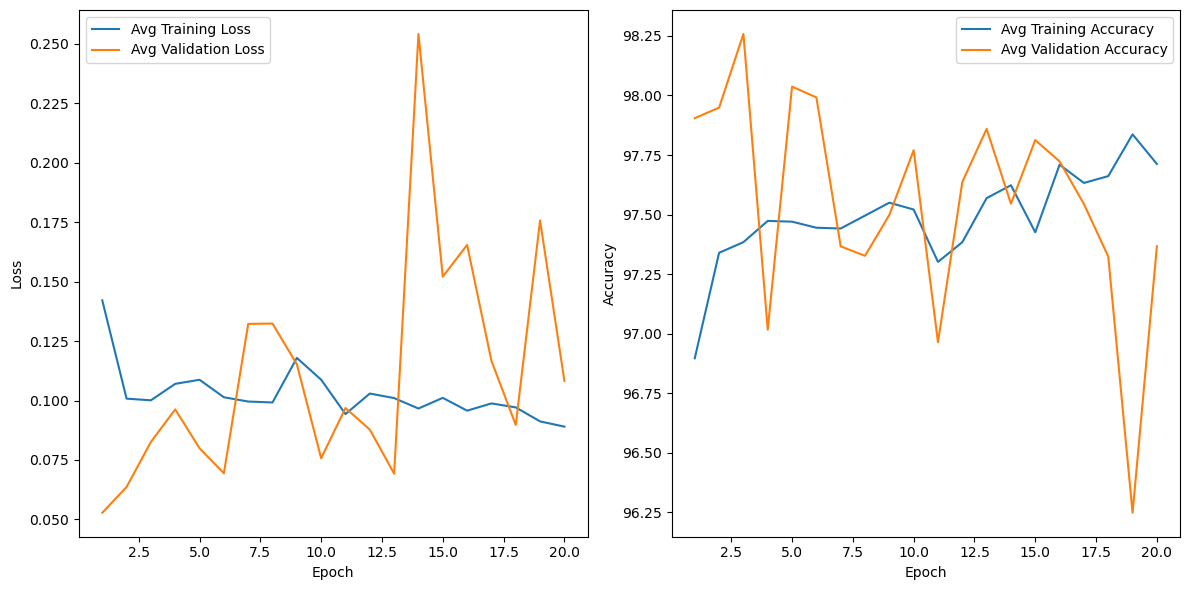

In [14]:
# Imprimir e traçar métricas de desempenho médio
for epoch in range(1, 21):
    print('.' * 111)
    print(f'Epoch: {epoch}, Avg Training Loss: {avg_train_losses[epoch - 1]:.2f}, Avg Training Accuracy: {avg_train_accuracies[epoch - 1]:.2f}%, Avg Validation Loss: {avg_val_losses[epoch - 1]:.2f}, Avg Validation Accuracy: {avg_val_accuracies[epoch - 1]:.2f}%')
    print()

# Plota as métricas de desempenho médio
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, 21), avg_train_losses, label='Avg Training Loss')
plt.plot(range(1, 21), avg_val_losses, label='Avg Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, 21), avg_train_accuracies, label='Avg Training Accuracy')
plt.plot(range(1, 21), avg_val_accuracies, label='Avg Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()